# Implementing two layer net

In this article we are going to implement a two layer neural network and test on a merge of both datasets CK+ and JAFFE for emotion recognition.

In [3]:
# Some import
import numpy as np
import matplotlib.pyplot as plt

# services to crop and extract features
# for dimensional reduction
from utils import FaceCropper
from utils import EmotionFeatures
%matplotlib inline

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [ ]:
# my local dataset
dataset_path = "/Users/mohamed/Code/dataset/ckplus_jaffe"

# load dataset images & croppe faces with labels
faceCropper = FaceCropper("/Users/mohamed/Code/dataset/ckplus_jaffe/ckplus_jaffe_dataset")
images, labels = faceCropper.cropper_lift()

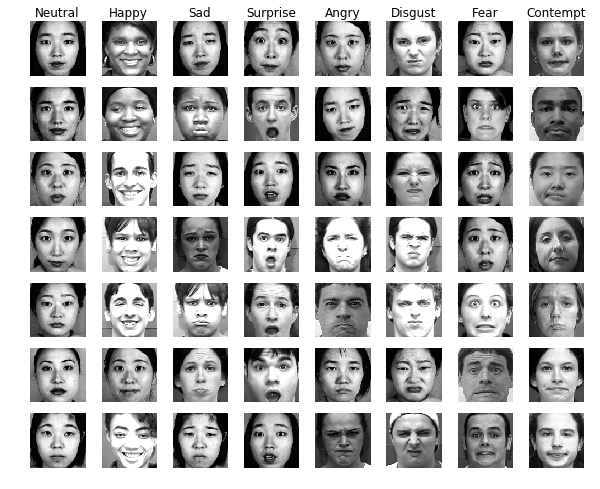

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Angry', 'Disgust', 'Fear', 'Contempt']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(labels == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(images.reshape(-1, 100,100)[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# printing shapes of our data
# Note that Images are resized to 100 x 100 pixels and flatten to a vector
print 'images shape ', images.shape,
print 'labels shape ', labels.shape

images shape  (541, 10000) labels shape  (541,)


In [17]:
# TwoLayerNet object
# -------------------
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """
    
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def loss(self, X, y=None, reg=0.0):
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None

        h1 = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(h1, W2) + b2

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None

        scores_ = scores
        scores_ -= np.max(scores_, axis=1).reshape(-1, 1)
        exp_scores = np.exp(scores_) 
        normal_scores = exp_scores / np.sum(exp_scores, axis=1).reshape(-1, 1)

        scores_ = normal_scores

        loss =  np.sum(-np.log(scores_[range(y.shape[0]), y]))

        loss /= y.shape[0]
        Reg = 0.5 * reg * ( np.sum(W1 * W1) + np.sum(W2 * W2))

        loss = loss + Reg

        # Backward pass: compute gradients
        grads = {}
        dscores = normal_scores
        dscores[range(y.shape[0]), y] -=1
        dscores /= y.shape[0]

        # first backpro scores = np.dot(h1, W2) + b2
        dW2 = np.dot(h1.T, dscores)
        db2 = np.sum(dscores, axis=0)

        # adding regulari
        dW2 += reg * W2

        grads['W2'] = dW2
        grads['b2'] = db2
        # second packpro hidded layer
        dh1 = np.dot(dscores, W2.T)

        # 3 packpro ReLU h1 = np.maximum(0, np.dot(X, W1) + b1)
        dh1[h1 <= 0] = 0

        # 4 backpro W1, b1
        dW1 = np.dot(X.T, dh1)
        db1 = np.sum(dh1, axis=0)

        dW1 += reg * W1

        grads['W1'] = dW1
        grads['b1'] = db1

        return loss, grads
    
    def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []


        for it in xrange(num_iters):
            X_batch = None
            y_batch = None


            mask = np.random.choice(num_train, batch_size)
            X_batch = X[mask]
            y_batch = y[mask]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)


            self.params['W1'] += -learning_rate * grads['W1']
            self.params['b1'] += -learning_rate * grads['b1']
            self.params['W2'] += -learning_rate * grads['W2']
            self.params['b2'] += -learning_rate * grads['b2']

            if verbose and it % 100 == 0:
                print 'iteration %d / %d: loss %f' % (it, num_iters, loss)

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }


    
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        h1 = np.maximum(0, np.dot(X, self.params['W1']) + self.params['b1'])
        scores = np.dot(h1, self.params['W2']) + self.params['b2']
        y_pred = np.argmax(scores, axis=1)
        
        return y_pred

In [18]:
# some helper methods 
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

## Forward pass: compute scores

In [19]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# Sanity check the difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207103e-08


## Forward pass: compute loss

In [20]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
1.79856129989e-13


## Backward pass

In [21]:
from utils.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.1)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b2 max relative error: 4.447625e-11
b1 max relative error: 2.738421e-09


## Train the network

iteration 0 / 100: loss 1.241994
Final training loss:  0.0171496079387


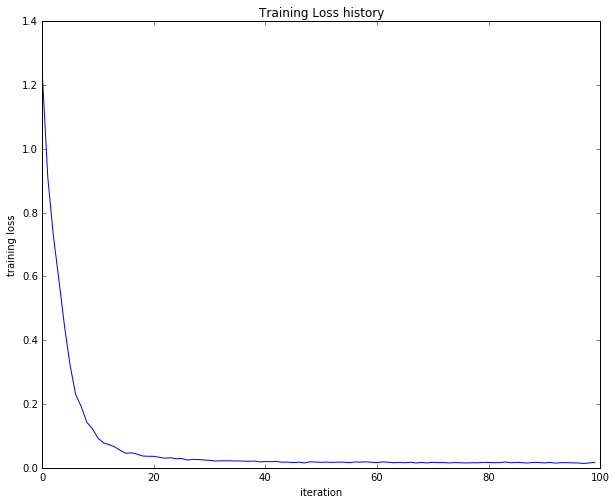

In [22]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=True)

print 'Final training loss: ', stats['loss_history'][-1]

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [32]:
# sampling data to training, validation and test sets

test_percent = 0.25
valid_percent = 0.20
num_samples = images.shape[0]
test_mask = np.random.choice(num_samples, int(num_samples * test_percent))

X_train = np.delete(images, test_mask, axis=0)
y_train = np.delete(labels, test_mask)

X_test = images[test_mask]
y_test = labels[test_mask]

val_mask = np.random.choice(X_train.shape[0], int(X_train.shape[0] * valid_percent))

X_val = X_train[val_mask]
y_val = y_train[val_mask]

X_train = np.delete(X_train, val_mask, axis=0)
y_train = np.delete(y_train, val_mask)

# print shapes after data split
print 'X_train ', X_train.shape
print 'y_train ', y_train.shape
print 'X_test ', X_test.shape
print 'y_test ', y_test.shape
print 'X_val ', X_val.shape
print 'y_val ', y_val.shape

X_train  (345, 10000)
y_train  (345,)
X_test  (135, 10000)
y_test  (135,)
X_val  (84, 10000)
y_val  (84,)


In [33]:
input_size = 100 * 100
hidden_size = 50
num_classes = 8
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc


iteration 0 / 1000: loss 2.080926
iteration 100 / 1000: loss 1.987295
iteration 200 / 1000: loss 1.990948
iteration 300 / 1000: loss 1.967360
iteration 400 / 1000: loss 1.950053
iteration 500 / 1000: loss 1.948301
iteration 600 / 1000: loss 1.956372
iteration 700 / 1000: loss 1.952227
iteration 800 / 1000: loss 1.965079
iteration 900 / 1000: loss 1.966433
Validation accuracy:  0.190476190476


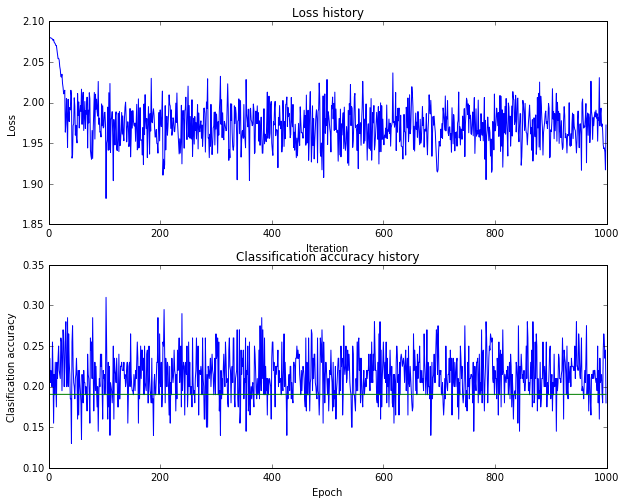

In [34]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [35]:
input_size = 100 * 100
hidden_size = 60
num_classes = 8
best_net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.8, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

iteration 0 / 10000: loss 2.081743
iteration 100 / 10000: loss 1.927698
iteration 200 / 10000: loss 1.910750
iteration 300 / 10000: loss 1.885865
iteration 400 / 10000: loss 1.900564
iteration 500 / 10000: loss 1.871211
iteration 600 / 10000: loss 1.926184
iteration 700 / 10000: loss 1.889833
iteration 800 / 10000: loss 1.900879
iteration 900 / 10000: loss 1.887592
iteration 1000 / 10000: loss 1.916814
iteration 1100 / 10000: loss 1.955669
iteration 1200 / 10000: loss 1.945082
iteration 1300 / 10000: loss 1.881486
iteration 1400 / 10000: loss 1.871538
iteration 1500 / 10000: loss 1.894598
iteration 1600 / 10000: loss 1.941547
iteration 1700 / 10000: loss 1.941502
iteration 1800 / 10000: loss 1.911391
iteration 1900 / 10000: loss 1.876105
iteration 2000 / 10000: loss 1.914932
iteration 2100 / 10000: loss 1.929668
iteration 2200 / 10000: loss 1.903265
iteration 2300 / 10000: loss 1.941037
iteration 2400 / 10000: loss 1.942670
iteration 2500 / 10000: loss 1.880098
iteration 2600 / 10000: 

In [48]:
from utils import EmotionFeatures
emotion_features = EmotionFeatures(X_train.reshape(-1, 100, 100).astype('uint8'))
X_train_landmarks = emotion_features.face_landmarks_features()


In [49]:
emotion_features = EmotionFeatures(X_val.reshape(-1, 100, 100).astype('uint8'))
X_val_landmarks = emotion_features.face_landmarks_features()

In [59]:
emotion_features = EmotionFeatures(X_train)
X_train_pca = emotion_features.pca_features_new()

emotion_features = EmotionFeatures(X_val)
X_val_pca = emotion_features.pca_features_new()

In [61]:
X_train_pca.shape

(345, 100)

In [64]:
input_size = 100
hidden_size = 20
num_classes = 8
best_net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = best_net.train(X_train_pca, y_train, X_val_pca, y_val,
            num_iters=1000, batch_size=345,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=0.8, verbose=False)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print 'Validation accuracy: ', val_acc

Validation accuracy:  0.214285714286
